# Bottom Age

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.append("/home/142/cs6673/work/iav_AABW/Python_scripts/") 
from iav_AABW_functions import (
    select_bottom_values, shelf_mask_isobath, mask_from_polygon, yearly_mean, correlation_3D)

## plotting
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37545,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:42977,Total threads: 6
Dashboard: /proxy/41745/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:45099,


## Parameters

In [4]:
expt = 'panan_005deg_jra55_ryf_2023_05_17'
expt_name = 'panan_005deg_jra55_ryf'
db = expt_name + '.db'

session = cc.database.create_session(db)

# create database
directory_list = ['/scratch/e14/cs6673/mom6/archive/' + expt + '/']
cc.database.build_index(directory_list, session)

year_all = range(1991, 1998)
frequency = '1 monthly'
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
path_Plots = '/g/data/e14/cs6673/mom6_comparison/Plots_DSW/'

resolution = expt_name.split('_')[1][:-3]
resolution

Indexing experiment: panan_005deg_jra55_ryf_2023_05_17


'005'

In [4]:
expt = 'panan-01-test-oldparams'
expt_name = 'panan_01deg_jra55_ryf'
db = expt_name + '.db'

session = cc.database.create_session(db)

# create database
directory_list = ['/scratch/x77/akm157/mom6/archive/panan-01-test-oldparams/']
cc.database.build_index(directory_list, session)

year_all = range(1991, 2010, 10)
frequency = '1 monthly'
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
path_Plots = '/g/data/e14/cs6673/mom6_comparison/Plots_DSW/'

resolution = expt_name.split('_')[1][:-3]
resolution

Indexing experiment: panan-01-test-oldparams


'01'

In [5]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea']}

## Load data

In [6]:
depth = cc.querying.getvar(
    expt, 'deptho', session, n=1,
    chunks={'xh': '200MB', 'yh': '200MB'})
land_mask = (depth*0).fillna(1)

In [7]:
# calculated and saved in cell below
age = xr.open_mfdataset(
    path_output + 'Age_bottom_' + expt_name + '*.nc').agessc
# normalized
age_norm = age/xr.DataArray(
    np.linspace(age[0, :].max(), age[-1, :].max(), len(age.time)), dims='time')

In [8]:
def select_bottom_values(var, land_mask):
    depth_array = var*0 + var.z_l
    max_depth = depth_array.max(dim='z_l', skipna=True)

    var_b = var.where(depth_array.z_l >= max_depth)
    var_b = var_b.sum(dim='z_l').compute()
    var_b = var_b.where(land_mask == 0)
    return var_b

## Plots and movies

In [9]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

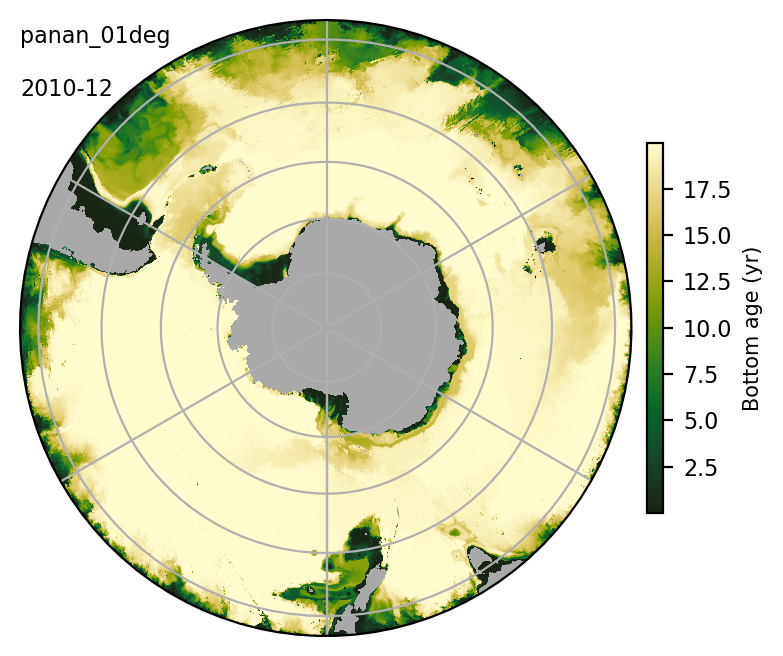

In [10]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(4, 4), dpi=200, subplot_kw={
        'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -37], proj)
ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines(draw_labels=False)

p = plt.pcolormesh(
    age.xh, age.yh, age[-1, :],
    cmap=cmo.speed_r, transform=proj)
plt.contourf(land_mask.xh.values,
             np.concatenate(([-90], land_mask.yh[1:].values)),
             land_mask, colors='darkgrey', levels=[0.5, 2],
             transform=proj)

plt.title(expt_name[:-10] + '\n \n' + str(age_norm.time[-1].values)[:7],
          fontsize=8, loc='left', y=.85)

pos = ax.get_position()
cax = plt.axes([pos.xmax+.02, pos.ymin+.2*(pos.ymax-pos.ymin),
                0.02, .6*(pos.ymax-pos.ymin)])
cbar = plt.colorbar(p, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylabel('Bottom age (yr)', fontsize=7.5)

plt.show()

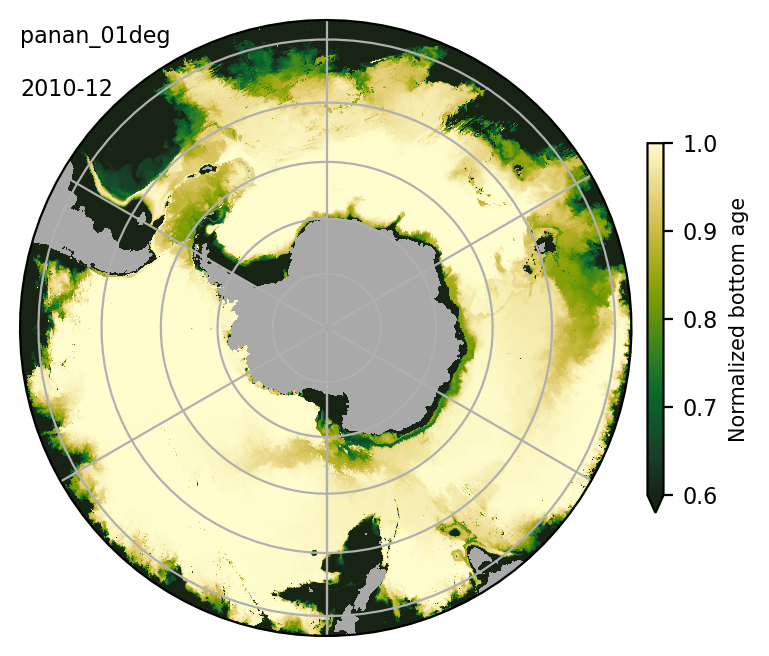

In [11]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(4, 4), dpi=200, subplot_kw={
        'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -37], proj)
ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines(draw_labels=False)

p = plt.pcolormesh(
    age_norm.xh, age_norm.yh, age_norm[-1, :],
    cmap=cmo.speed_r, vmin=.6, vmax=1, transform=proj)
plt.contourf(land_mask.xh.values,
             np.concatenate(([-90], land_mask.yh[1:].values)),
             land_mask, colors='darkgrey', levels=[0.5, 2],
             transform=proj)

plt.title(expt_name[:-10] + '\n \n' + str(age_norm.time[-1].values)[:7],
          fontsize=8, loc='left', y=.85)

pos = ax.get_position()
cax = plt.axes([pos.xmax+.02, pos.ymin+.2*(pos.ymax-pos.ymin),
                0.02, .6*(pos.ymax-pos.ymin)])
cbar = plt.colorbar(p, cax=cax, orientation='vertical', extend='min')
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylabel('Normalized bottom age', fontsize=7.5)

plt.show()

In [12]:
# select every 3rd month
age_norm_plot = age_norm[::3, :, :]

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(4, 3.5), dpi=200, subplot_kw={
        'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -37], proj)
ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines(draw_labels=False)

p = plt.pcolormesh(
    age_norm_plot.xh, age_norm_plot.yh, age_norm_plot[0, :],
    cmap=cmo.speed_r, vmin=.6, vmax=1, transform=proj)
plt.contourf(land_mask.xh.values,
             np.concatenate(([-90], land_mask.yh[1:].values)),
             land_mask, colors='darkgrey', levels=[0.5, 2],
             transform=proj)

plt.title(expt_name[:-10] + '\n \n' +
          str(age_norm_plot.time[-1].values)[:7],
          fontsize=8, loc='left', y=.85)

pos = ax.get_position()
cax = plt.axes([pos.xmax+.02, pos.ymin+.2*(pos.ymax-pos.ymin),
                0.02, .6*(pos.ymax-pos.ymin)])
cbar = plt.colorbar(p, cax=cax, orientation='vertical', extend='min')
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylabel('Normalized bottom age', fontsize=7.5)

def animate(i):
    p.set_array(age_norm_plot[i, :, :].values.flatten())
    ax.set_title(
        expt_name[:-10] + '\n \n' +
        str(age_norm_plot.time[i].values)[:7],
        fontsize=8, loc='left', y=.85)

anim = FuncAnimation(
    fig, animate, interval=500, frames=len(age_norm_plot.time)-1)

anim.save(path_Plots + 'Age_bottom_normalized_' + expt_name +
          '_every_3rd_months.mp4', writer='ffmpeg', fps=1, dpi=200)

plt.close()
HTML(anim.to_html5_video())

In [10]:
# select every 3rd month
age_norm_plot = age_norm[::3, :, :]

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(4, 3.5), dpi=200, subplot_kw={
        'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -37], proj)
ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines(draw_labels=False)

p = plt.pcolormesh(
    age_norm_plot.xh, age_norm_plot.yh, age_norm_plot[0, :],
    cmap=cmo.speed_r, vmin=.6, vmax=1, transform=proj)
plt.contourf(land_mask.xh.values,
             np.concatenate(([-90], land_mask.yh[1:].values)),
             land_mask, colors='darkgrey', levels=[0.5, 2],
             transform=proj)

plt.title(expt_name[:-10] + '\n \n' +
          str(age_norm_plot.time[-1].values)[:7],
          fontsize=8, loc='left', y=.85)

pos = ax.get_position()
cax = plt.axes([pos.xmax+.02, pos.ymin+.2*(pos.ymax-pos.ymin),
                0.02, .6*(pos.ymax-pos.ymin)])
cbar = plt.colorbar(p, cax=cax, orientation='vertical', extend='min')
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylabel('Normalized bottom age', fontsize=7.5)

def animate(i):
    p.set_array(age_norm_plot[i, :, :].values.flatten())
    ax.set_title(
        expt_name[:-10] + '\n \n' +
        str(age_norm_plot.time[i].values)[:7],
        fontsize=8, loc='left', y=.85)

anim = FuncAnimation(
    fig, animate, interval=500, frames=len(age_norm_plot.time)-1)

anim.save(path_Plots + 'Age_bottom_normalized_' + expt_name +
          '_every_3rd_months.mp4', writer='ffmpeg', fps=1, dpi=200)

plt.close()
HTML(anim.to_html5_video())